### 필요라이브러리 생성

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [2]:
### 기존 라벨링 annotation 불러오기
labelpath = '/home/piai/다운로드/customdataset/annotation/'
label_lst = os.listdir(labelpath)
label_lst.sort()
len(label_lst)

17248

In [3]:
### 기존 이미지 파일 불러오기
imgpath = '/home/piai/다운로드/customdataset/origin_image/'
label_img = os.listdir(imgpath)
label_img.sort()
len(label_img)

17248

In [4]:
### 기존 라벨링 annotation을 한번에 다 불러와 전체 데이터프레임 만들기
totaldf = pd.DataFrame()
for name in label_lst:
    with open(labelpath + name) as f:
        data = json.load(f)
    df = pd.DataFrame(data['annotations'])
    totaldf = pd.concat([totaldf, df])
totaldf.reset_index(inplace=True, drop=True)

In [5]:
print(len(totaldf))
totaldf.head(10)

99046


,id,image_id,category_id,segmentation,area,bbox,damage,part,year,color,level,repair
0,2,1,as-0031772,"[[[[222, 500], [223, 524], [220, 531], [218, 5...",101.5,"[218, 500, 5, 31]",Scratched,None,2015,Black,NaN,[]
1,3,1,as-0031772,"[[[[528, 423], [612, 403], [615, 414], [629, 4...",1572.0,"[528, 403, 101, 31]",Crushed,None,2015,Black,NaN,[]
2,4,1,as-0031772,"[[[[139, 404], [159, 402], [159, 410], [141, 4...",124.0,"[139, 402, 20, 8]",Scratched,None,2015,Black,NaN,[]
3,5,1,as-0031772,"[[[[141, 417], [161, 416], [160, 421], [142, 4...",85.5,"[141, 416, 20, 5]",Scratched,None,2015,Black,NaN,[]
4,6,1,as-0031772,"[[[[375, 260], [388, 268], [377, 267], [375, 2...",37.5,"[375, 260, 13, 8]",Scratched,None,2015,Black,NaN,[]
5,7,1,as-0031772,"[[[[550, 257], [579, 254], [610, 254], [583, 2...",347.5,"[550, 254, 60, 11]",Scratched,None,2015,Black,NaN,[]
6,8,1,as-0031772,"[[[[368, 405], [374, 408], [368, 417], [363, 4...",66.0,"[363, 405, 11, 12]",Scratched,None,2015,Black,NaN,[]
7,9,1,as-0031772,"[[[[420, 420], [371, 415], [372, 410], [384, 4...",1411.5,"[371, 403, 122, 17]",Crushed,None,2015,Black,NaN,[]
8,19,1,as-0031772,"[[[[139, 236], [147, 195], [214, 204], [251, 2...",104793.0,"[139, 190, 573, 251]",None,Trunk lid,2015,Black,4.0,[]
9,20,1,as-0031772,"[[[[82, 309], [89, 314], [98, 317], [123, 322]...",85653.5,"[82, 293, 648, 274]",None,Rear bumper,2015,Black,4.0,[]


In [6]:
### 우리가 라벨링할 부분은 파손이 아닌 part가 나와있는 걸 BBOX로 라벨링을 진행할 예정이기 때문에
### part 부분이 없는 데이터는 다 삭제한다. 
totaldf2 = totaldf[~totaldf['part'].isna()]
totaldf2.reset_index(inplace=True, drop=True)
totaldf2.category_id.nunique()

15678

- 1570개의 이미지가 아무 part가 없는 걸 알 수가 있음
- 해당 이미지들은 data로 사용하지 않을 예정으로 모든 클래스가 존재하지 않는 이미지를 데이터셋에서 제외하는 것이 좋다고 판단. 이러한 이미지들은 모델의 학습에 도움이 되지 않을 뿐더러, 모델의 성능을 저하시킬 가능성이 있기 때문이다.

In [7]:
totaldf2.head()

,id,image_id,category_id,segmentation,area,bbox,damage,part,year,color,level,repair
0,19,1,as-0031772,"[[[[139, 236], [147, 195], [214, 204], [251, 2...",104793.0,"[139, 190, 573, 251]",None,Trunk lid,2015,Black,4.0,[]
1,20,1,as-0031772,"[[[[82, 309], [89, 314], [98, 317], [123, 322]...",85653.5,"[82, 293, 648, 274]",None,Rear bumper,2015,Black,4.0,[]
2,8,1,sc-203122,"[[[[180, 389], [195, 392], [219, 403], [265, 4...",93420.0,"[50, 381, 505, 461]",None,Front fender(R),2019,White,4.0,[]
3,9,1,sc-203122,"[[[[499, 512], [513, 493], [522, 484], [527, 4...",16761.5,"[499, 348, 137, 303]",None,Front bumper,2019,White,4.0,[]
4,11,1,as-0082746,"[[[[169, 329], [171, 332], [170, 337], [171, 3...",24793.5,"[146, 329, 266, 177]",None,Rear bumper,2014,Others,4.0,"[Rear door(R):exchange,coating,sheet_metal, Fr..."


### 클래스 가공
- 이유는 기존 왼쪽 오른쪽 부품을 구분했으나 이후 모델에서는 클래스에서 구분을 추가적으로 진행하지 않았기 때문에 통일하기 위해서
- 다시 가공
- 기존 클래스 수 :32개 , 다음과 같이 진행했었음
{'Trunk lid': 0,
 'Rear bumper': 1,
 'Front fender(R)': 2,
 'Front bumper': 3,
 'Rear door(R)': 4,
 'Front door(R)': 5,
 'Bonnet': 6,
 'Rocker panel(R)': 7,
 'Front fender(L)': 8,
 'Rear fender(L)': 9,
 'Rear door(L)': 10,
 'Rear lamp(R)': 11,
 'Front Wheel(R)': 12,
 'Head lights(R)': 13,
 'Front door(L)': 14,
 'Rocker panel(L)': 15,
 'Head lights(L)': 16,
 'Rear lamp(L)': 17,
 'Rear fender(R)': 18,
 'Rear Wheel(L)': 19,
 'Side mirror(L)': 20,
 'Side mirror(R)': 21,
 'Rear Wheel(R)': 22,
 'Front Wheel(L)': 23,
 'Roof': 24,
 'Windshield': 25,
 'Rear windshield': 26,
 'C pillar(R)': 27,
 'A pillar(R)': 28,
 'A pillar(L)': 29,
 'Undercarriage': 30,
 'C pillar(L)': 31}

In [8]:
totaldf2['part'] = totaldf2['part'].apply(lambda x: x.replace('(R)','').replace('(L)',''))

/tmp/ipykernel_12516/518031281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totaldf2['part'] = totaldf2['part'].apply(lambda x: x.replace('(R)','').replace('(L)',''))


In [9]:
### 클래스 정리하기 - 각 파트별 클래스 번호 부여
part_lst = totaldf2.part.unique().tolist()
class_dict = {}
for i in range(len(part_lst)):
    class_dict[part_lst[i]] = i
class_dict

{'Trunk lid': 0,
 'Rear bumper': 1,
 'Front fender': 2,
 'Front bumper': 3,
 'Rear door': 4,
 'Front door': 5,
 'Bonnet': 6,
 'Rocker panel': 7,
 'Rear fender': 8,
 'Rear lamp': 9,
 'Front Wheel': 10,
 'Head lights': 11,
 'Rear Wheel': 12,
 'Side mirror': 13,
 'Roof': 14,
 'Windshield': 15,
 'Rear windshield': 16,
 'C pillar': 17,
 'A pillar': 18,
 'Undercarriage': 19}

### 라벨 데이터 생성

##### YOLO에 넣을 데이터 셋의 라벨 데이터 형식은 다음과 같다.
- 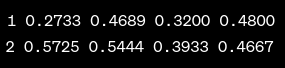
- object-class x y width height  형태로 표현

- 예를 들면 다음 이미지는 image.shape이 (600, 800, 3)이다.
- 그리고 내가 그리는 BBOX는 다음과 같은 코드로 그릴 수 있다.
- cv2.rectangle(image, (82, 293), (730, 567), color=(0,0,225), thickness=2)
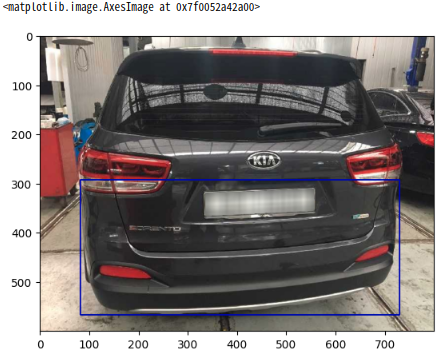
- 해당 경우 만들어지는 다음과 같다.
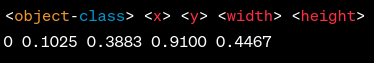
- object-class는 해당 객체의 클래스 인덱스 번호를 나타내며, 0은 클래스 인덱스 번호가 0인 경우를 의미한다.
- x, y는 BBox의 좌상단 좌표를 이미지 크기에 상대적인 비율로 표현한 값이며, 0.1025는 x 좌표를 의미하고 0.3883은 y 좌표를 의미한다
- width와 height는 BBox의 너비와 높이를 이미지 크기에 대한 비율로 표현한 값이며, 0.9100은 width를 의미하고 0.4467은 height를 의미한다.

- 또한, 다음과 같은 사례도 있다.
- 클래스가 사람(person), 개(dog), 고양이(cat) 세 개인데 특정 이미지에는 개와 고양이만 존재하는 경우, YOLO 포맷의 텍스트 파일은 다음과 같다.
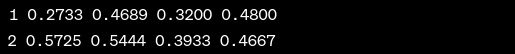

In [10]:
### 라벨링 텍스트 파일 생성 함수 코드
def save_annotations_to_txt(file_path, labels):
    """
    YOLO 포맷에 맞춰 객체 정보를 텍스트 파일로 저장하는 함수
    
    Args:
        file_path (str): 저장할 텍스트 파일 경로
        labels (list): 객체 정보 리스트. 각 객체 정보는 (class_id, x_center, y_center, width, height) 형태의 튜플이다.
    """
    with open(file_path, 'w') as f:
        for label in labels:
            class_id, x_center, y_center, width, height = label
            line = f"{class_id} {x_center} {y_center} {width} {height}\n"
            f.write(line)

In [11]:
totaldf2

,id,image_id,category_id,segmentation,area,bbox,damage,part,year,color,level,repair
0,19,1,as-0031772,"[[[[139, 236], [147, 195], [214, 204], [251, 2...",104793.0,"[139, 190, 573, 251]",None,Trunk lid,2015,Black,4.0,[]
1,20,1,as-0031772,"[[[[82, 309], [89, 314], [98, 317], [123, 322]...",85653.5,"[82, 293, 648, 274]",None,Rear bumper,2015,Black,4.0,[]
2,8,1,sc-203122,"[[[[180, 389], [195, 392], [219, 403], [265, 4...",93420.0,"[50, 381, 505, 461]",None,Front fender,2019,White,4.0,[]
3,9,1,sc-203122,"[[[[499, 512], [513, 493], [522, 484], [527, 4...",16761.5,"[499, 348, 137, 303]",None,Front bumper,2019,White,4.0,[]
4,11,1,as-0082746,"[[[[169, 329], [171, 332], [170, 337], [171, 3...",24793.5,"[146, 329, 266, 177]",None,Rear bumper,2014,Others,4.0,"[Rear door(R):exchange,coating,sheet_metal, Fr..."
...,...,...,...,...,...,...,...,...,...,...,...,...
29800,5,1,as-0045592,"[[[[147, 279], [141, 266], [131, 251], [125, 2...",8821.0,"[87, 123, 103, 194]",None,Front fender,2017,White,4.0,"[Front bumper:repair,coating, Front fender(L):..."
29801,4,1,as-0008985,"[[[[222, 198], [259, 284], [309, 385], [279, 4...",39061.5,"[134, 11, 175, 520]",None,Front bumper,2018,Others,4.0,"[Front door(L):exchange,coating, Front Wheel(L..."
29802,9,1,sc-182232,"[[[[63, 136], [64, 97], [67, 74], [72, 67], [1...",26638.5,"[52, 36, 124, 322]",None,Rear door,2016,White,4.0,"[Rear fender(R):exchange, Front bumper:coating..."
29803,10,1,sc-182232,"[[[[104, 338], [160, 353], [239, 386], [313, 4...",4751.5,"[104, 338, 233, 119]",None,Rocker panel,2016,White,4.0,"[Rear fender(R):exchange, Front bumper:coating..."


In [12]:
img_lst = [x for x in label_img if x.split('_')[-1].replace('.jpg','') in totaldf2.category_id.unique().tolist()]
len(img_lst), totaldf2.category_id.nunique()

(17248, 15678)

- 해당 코드를 통해 현재 1대1 매칭이 되지 않다는 사실을 발견

In [13]:
img_cnt = [x.split('_')[-1].replace('.jpg','') for x in img_lst]
img_cnt = Counter(img_cnt)

In [14]:
cnt = 0
values = 0
for idno in img_cnt.keys():
    if img_cnt[idno] != 1:
        cnt += 1
        values += (img_cnt[idno]-1)
cnt, values

(1365, 1570)

- 특정 이미지는 여러개가 매치된다는 것을 알았음.
- 해당 이미지 전처리는 직접 확인하고 라벨링하기에는 수가 너무 많아 제거하기로 결정

In [15]:
### 다시 img_lst 만들기, totaldf2도 필터링 진행(하나만 있는걸로)
img_lst = [x for x in label_img if img_cnt[x.split('_')[-1].replace('.jpg','')] == 1]
len(img_lst)

14313

In [16]:
totaldf2 = totaldf2[totaldf2.category_id.isin([x.split('_')[-1].replace('.jpg','') for x in img_lst])]
totaldf2.reset_index(inplace=True, drop=True)
len(totaldf2), totaldf2.category_id.nunique()

(23941, 14313)

### 라벨 데이터 만들기 코드

Original Image Shape : (600, 800, 3)


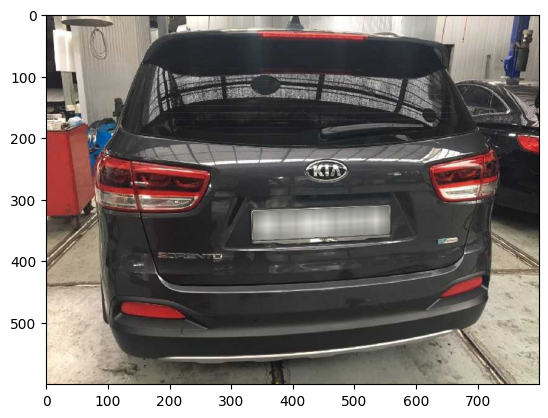

In [17]:
### 예시 
img = cv2.imread(imgpath + img_lst[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f'Original Image Shape : {img.shape}')
plt.imshow(img)
plt.show()

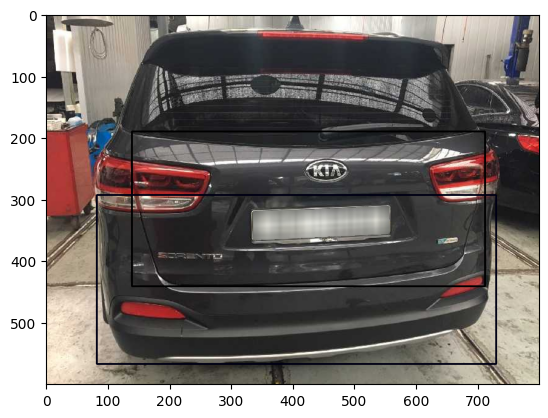

In [18]:
imgannotationdf = totaldf2[totaldf2['category_id'] == img_lst[0].replace('.jpg','').split('_')[-1]].reset_index(drop=True)
for i in range(len(imgannotationdf)):
    k = imgannotationdf.loc[i]['segmentation'][0][0]
    cv2.rectangle(img, (min([x[0] for x in k]), min([x[1] for x in k])), (max([x[0] for x in k]), max([x[1] for x in k])), color=(0,0,i*20), thickness=2)
plt.imshow(img)

In [19]:
img_labels = []
# img_lst[1].replace('.jpg','').split('_')[-1]
img_y = img.shape[0]
img_x = img.shape[1]
for i in range(len(imgannotationdf)):
    k = imgannotationdf.loc[i]['segmentation'][0][0]
    class_id = class_dict[imgannotationdf.loc[i]['part']]
    x0, y0, x1, y1 = min([x[0] for x in k]), min([x[1] for x in k]), max([x[0] for x in k]), max([x[1] for x in k])
    x, y, w, h = x0, y0, x1-x0, y1-y0
    img_w, img_h = img.shape[1], img.shape[0]
    x /= img_w
    y /= img_h
    w /= img_w
    h /= img_h
    class_label = (class_id, round(x,4), round(y,4), round(w,4), round(h,4))
    img_labels.append(class_label)
img_labels

[(0, 0.1737, 0.3167, 0.7163, 0.4183), (1, 0.1025, 0.4883, 0.81, 0.4567)]

In [20]:
### 새로운데이터셋 형성 path 생성
newimgpath = '/home/piai/다운로드/customdataset/images/'
newlabelpath = '/home/piai/다운로드/customdataset/labels/'
imgpath

'/home/piai/다운로드/customdataset/origin_image/'

In [21]:
# import shutil
# for img_name in img_lst:
#     shutil.copy(imgpath + img_name, newimgpath + img_name)

In [22]:
for img_name in img_lst:
    img = cv2.imread(newimgpath + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgannotationdf = totaldf2[totaldf2['category_id'] == img_name.replace('.jpg','').split('_')[-1]].reset_index(drop=True)

    img_labels = []
    # img_lst[1].replace('.jpg','').split('_')[-1]
    img_y = img.shape[0]
    img_x = img.shape[1]
    for i in range(len(imgannotationdf)):
        k = imgannotationdf.loc[i]['segmentation'][0][0]
        class_id = class_dict[imgannotationdf.loc[i]['part']]
        x0, y0, x1, y1 = min([x[0] for x in k]), min([x[1] for x in k]), max([x[0] for x in k]), max([x[1] for x in k])
        x, y, w, h = x0, y0, x1-x0, y1-y0
        img_w, img_h = img.shape[1], img.shape[0]
        x /= img_w
        y /= img_h
        w /= img_w
        h /= img_h
        class_label = (class_id, round(x,4), round(y,4), round(w,4), round(h,4))
        img_labels.append(class_label)
    filepath = newlabelpath + img_name.replace('.jpg','.txt')
    save_annotations_to_txt(filepath, img_labels)

### train, valid, test 데이터로 나누기

In [32]:
(len(os.listdir(newimgpath))-3)*0.8, (len(os.listdir(newimgpath))-3)*0.1, (len(os.listdir(newimgpath))-3)*0.1

(11450.400000000001, 1431.3000000000002, 1431.3000000000002)

In [33]:
(len(os.listdir(newimgpath))-3)*0.8 + (len(os.listdir(newimgpath))-3)*0.1 + (len(os.listdir(newimgpath))-3)*0.1

14313.0

In [34]:
11451 + 1431 + 1431

14313

### 코드를 통해서 파일 옮기기

In [37]:
imglist = os.listdir(newimgpath)
imglist = [x for x in imglist if '.jpg' in x]
imglist

['0008088_as-0010329.jpg',
 '0428951_as-0015100.jpg',
 '0205160_as-0052069.jpg',
 '0301400_sc-144781.jpg',
 '0127025_as-0079643.jpg',
 '0013937_as-0063365.jpg',
 '0168574_as-2831666.jpg',
 '0209120_sc-193907.jpg',
 '0241054_sc-1007730.jpg',
 '0034004_as-0037993.jpg',
 '0602636_sc-147681.jpg',
 '0276843_as-0063596.jpg',
 '0598864_as-0016773.jpg',
 '0057552_as-0083876.jpg',
 '0144415_sc-215356.jpg',
 '0202802_as-2659329.jpg',
 '0254078_sc-1034603.jpg',
 '0186620_sc-114048.jpg',
 '0067937_sc-128880.jpg',
 '0520498_as-0069589.jpg',
 '0254565_as-2852671.jpg',
 '0271022_as-0074001.jpg',
 '0116200_as-2546118.jpg',
 '0292584_sc-190256.jpg',
 '0460844_sc-116604.jpg',
 '0513973_as-0077712.jpg',
 '0033891_sc-107133.jpg',
 '0604484_as-0002987.jpg',
 '0002629_as-0017192.jpg',
 '0128109_as-0022172.jpg',
 '0297389_as-0041203.jpg',
 '0136833_as-0028094.jpg',
 '0468001_as-0062087.jpg',
 '0443007_sc-1003228.jpg',
 '0585277_sc-199327.jpg',
 '0573788_as-0086693.jpg',
 '0088640_as-2865720.jpg',
 '0280360_s

In [49]:
import os 
import shutil
for imgname in imglist[:11451]:
    shutil.move(newimgpath + imgname, newimgpath + 'train')
    shutil.move(newlabelpath + imgname.replace('.jpg','.txt'), newlabelpath +'train')
print('train 완료')
for imgname in imglist[11451:12882]:
    shutil.move(newimgpath + imgname, newimgpath + 'test')
    shutil.move(newlabelpath + imgname.replace('.jpg','.txt'), newlabelpath +'test')
print('test 완료')
for imgname in imglist[12882:]:
    shutil.move(newimgpath + imgname, newimgpath + 'valid')
    shutil.move(newlabelpath + imgname.replace('.jpg','.txt'), newlabelpath +'valid')
print('valid 완료')

train 완료
test 완료
valid 완료


In [50]:
class_dict

{'Trunk lid': 0,
 'Rear bumper': 1,
 'Front fender': 2,
 'Front bumper': 3,
 'Rear door': 4,
 'Front door': 5,
 'Bonnet': 6,
 'Rocker panel': 7,
 'Rear fender': 8,
 'Rear lamp': 9,
 'Front Wheel': 10,
 'Head lights': 11,
 'Rear Wheel': 12,
 'Side mirror': 13,
 'Roof': 14,
 'Windshield': 15,
 'Rear windshield': 16,
 'C pillar': 17,
 'A pillar': 18,
 'Undercarriage': 19}

In [51]:
print('\n- '.join(list(class_dict.keys())))

Trunk lid
- Rear bumper
- Front fender
- Front bumper
- Rear door
- Front door
- Bonnet
- Rocker panel
- Rear fender
- Rear lamp
- Front Wheel
- Head lights
- Rear Wheel
- Side mirror
- Roof
- Windshield
- Rear windshield
- C pillar
- A pillar
- Undercarriage


In [52]:
list(class_dict.keys())

['Trunk lid',
 'Rear bumper',
 'Front fender',
 'Front bumper',
 'Rear door',
 'Front door',
 'Bonnet',
 'Rocker panel',
 'Rear fender',
 'Rear lamp',
 'Front Wheel',
 'Head lights',
 'Rear Wheel',
 'Side mirror',
 'Roof',
 'Windshield',
 'Rear windshield',
 'C pillar',
 'A pillar',
 'Undercarriage']

In [56]:
with open(newlabelpath + 'valid/' + '0371995_as-3373704.txt') as f:
    for line in f:
        print(line.strip())

0 0.1638 0.26 0.7087 0.3867
1 0.1175 0.525 0.8 0.3633
